In [1]:
# analysis
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

sns.set_style('darkgrid')
np.set_printoptions(precision=3)
warnings.filterwarnings("ignore")

# missings (imputer)
# from sklearn.impute import SimpleImputer, KNNImputer

# interacciones
from sklearn.preprocessing import PolynomialFeatures

# transformaciones
from sklearn.compose import ColumnTransformer
# - variab numéricas
from sklearn.preprocessing import RobustScaler # MinMaxScaler, StandardScaler, Normalizer, Binarizer 
# from sklearn.preprocessing import PowerTransformer, BoxCox
# - variab categ
from sklearn.preprocessing import OneHotEncoder # LabelEncoder, OrdinalEncoder

# feature selection
from sklearn.feature_selection import f_classif # chi2
from sklearn.feature_selection import SelectKBest, SelectFromModel
from sklearn.feature_selection import RFE, RFECV
# from sklearn.decomposition import PCA

# algoritmos
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier # red neuronal

# bagging
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.ensemble import VotingClassifier, ExtraTreesClassifier

# boosting
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
# import xgboost as xgb

# model selection
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE, SMOTENC
from sklearn.pipeline import Pipeline #make_pipeline
from sklearn.model_selection import GridSearchCV # RandomizedSearchCV
from sklearn.model_selection import KFold, ShuffleSplit, LeaveOneOut, StratifiedKFold, RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score, cross_val_predict, ParameterGrid

# Técnicas de evaluación
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.metrics import make_scorer, accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import auc, roc_curve, roc_auc_score, RocCurveDisplay

In [2]:
# semilla de aleatorización

seed = 99

In [3]:
data = pd.read_csv('Datasets/datos_procesados.csv')

print(f'Número de filas: {data.shape[0]}, Númerode columnas:{data.shape[1]}')

Número de filas: 4687, Númerode columnas:24


In [4]:
# Separar en train y test
X_train = data[data['Dataset'] == 'train'].drop(['Dataset'], axis=1)
X_test = data[data['Dataset'] == 'test'].drop(['Dataset'], axis=1)

# variable objetivo (.pop elimina la col de X, que también es un paso necesario)
y_train = X_train.pop('Hazardous')
y_test = X_test.pop('Hazardous')

In [5]:
# SMOTE (remuestro de datos de entrenamiento desbalanceados)

# Probaremos a obtener el mejor modelo tanto con los train_data desbalanceados como balanceados con smote

categ_index = X_train.columns.get_loc('Orbit Uncertainity (categ)')

smote_nc = SMOTENC(categorical_features=[categ_index], # hay que indicarle cuál es la variab categ en el dataset que se va a transformar
             random_state=seed)

X_train_resampled, y_train_resampled = smote_nc.fit_resample(X_train, y_train)

## 2.a Bagging

* **Bagging** es crear varios modelos, todos del mismo algoritmo, entrenados con distintas muestras (bootstrapping), y sus resultados se promedian.

* **Random Forest** es un caso de bagging con árboles, donde cada árbol se construye utilizando una muestra bootstrapeada y una selección aleatoria de variabs en cada división del árbol.

In [6]:
""" Ayuda para la profe: """
# En R, la profe nos explicó bagging con este código:
    
# rfgrid<-expand.grid(mtry=c(6))

# control<-trainControl(method = "cv",number=4,
#                       savePredictions = "all",classProbs=TRUE) 

# rf<- train(data=saheartbis,
#  factor(chd)~age+tobacco+ldl+adiposity+obesity+famhist.Absent,
#  method="rf",trControl=control,tuneGrid=rfgrid,
#  linout = FALSE,ntree=5000,sampsize=200,nodesize=10,replace=TRUE)

# Estos paráms en R tiene su equivalente en Python:
    
# mtry --> max_features
# repeated cross_val --> n_splits, n_repeats
# indicar factor()~variables --> no es necesario definirlo así en python
# linout --> no tiene equivalente en sklearn, pero tampoco lo necesitamos
# ntree --> n_estimators
# sampsize --> max_samples
# nodesize --> min_samples_leaf
# replace --> bootstrap

# y no recuerdo dónde se indican en R, pero en Python también tenemos:
# max_depth (máxima profundidad del árbol)

' Ayuda para la profe: '

In [7]:
# 1ª etapa (with all features)

import time
start_time = time.time()

# Algoritmo a probar
model = BaggingClassifier(estimator=DecisionTreeClassifier(criterion='gini',
                                                           max_depth=5,
                                                           min_samples_leaf=40,
                                                           class_weight='balanced',
                                                           random_state=seed
                                                           ), random_state=seed)
# Otros args por dfto:
    # bootstrap=True
    # bootstrap_features=False (True sería RandomForest)
    # (oob_score=False (sería interesante ponerlo a True y ver cómo nos devuelve esa info)

# Definir variabs numéricas y categóricas
scaler_features = X_train.select_dtypes(include=[np.number]).columns.tolist()
categ_features = [feature for feature in X_train.columns if feature not in scaler_features]

# Column transformer
col_transformer = ColumnTransformer(
    [
    ('encoder', OneHotEncoder(drop=["3-9"]), ['Orbit Uncertainity (categ)']), # @@ necesario??
    ('scaler', RobustScaler(), scaler_features)
    ], remainder='passthrough')

##### no hace falta ejecutar esta parte, no hay paráms que buscar, podemos hacer solo la 2ª etapa

# # Definir instancia SMOTENC
# categ_index = X_train.columns.get_loc('Orbit Uncertainity (categ)')
# smote_nc = SMOTENC(categorical_features=[categ_index], # hay que indicarle cuál es la variab categ en el dataset que se va a transformar
#              random_state=seed)

# # Pipeline 1
# pipe = Pipeline([
# #         ('smote_nc', smote_nc), # quitarlo si class_weight='balanced'
#         ('column_transform', col_transformer),
#         ('polynomial', PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)), # añadir interacciones
#         ('algorithm', model)        
# ])

# # Tuneado del modelo (malla de paráms)
#     # Podríamos buscar los mejores paráms teniendo en cuenta también los paráms de cada árbol.
#     # Pero la ejecución tarda mucho, y en el apartado 2 ya vimos cuál era el mejor árbol para
#     # nuestro dataset, así que nos basamos en ese árbol (lo definimos arriba)
# parametros = {
#     "algorithm__n_estimators": [20,30,40], # número de árboles en el Bagging
#     "algorithm__max_samples": [0.5, 0.75, 1] # si 1, hace reemplazamiento (para que sea bootstrapping)
# #     "algorithm__max_features": [1] # dejamos que use todas, no queremos ahora RandomForest
# }

# Repeated cross_val (stratified)
# cv_technique = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)
cv_technique = RepeatedStratifiedKFold(n_splits=10, n_repeats=5, random_state=seed)

# # combinamos todo
# gsearch = GridSearchCV(estimator=pipe, cv=cv_technique, param_grid=parametros, scoring='f1')

# # buscamos el mejor modelo
# # opción a) sin resample y con class_weight='balanced':
# grid_model = gsearch.fit(X_train, y_train)

# # opción b) con resample (SMOTE)
# # grid_model = gsearch.fit(X_train_resampled, y_train_resampled)

# print("Best CV score:", grid_model.best_score_)

end_time = time.time()
print()
print("Tiempo de ejecución:", end_time - start_time, "segundos")


Tiempo de ejecución: 0.0010006427764892578 segundos


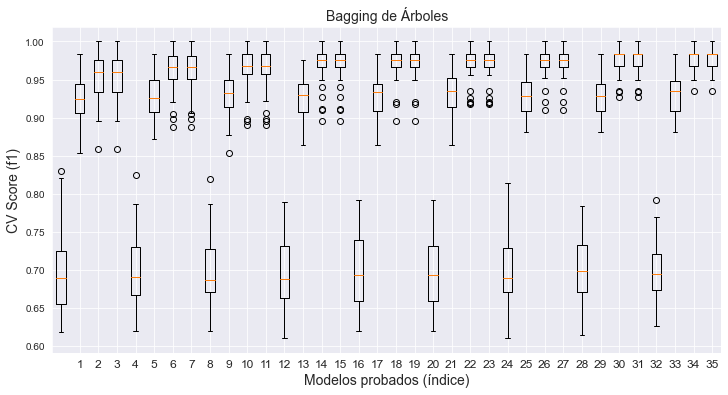


Tiempo de ejecución: 221.0719714164734 segundos


In [8]:
# 2ª etapa: boxplot para elegir el resto de paráms

# no podemos poner muchos paráms, o no veremos nada en los boxplots
# por eso aquí hay traer ya algunos paráms elegido


import time
start_time = time.time()

pipe_fs = Pipeline([
        ('column_transform', col_transformer),
        ('polynomial', PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)), # añadir interacciones
        ('feature_selection', SelectKBest(score_func=f_classif)), # k = número de variabs a seleccionar
#         ('algorithm', grid_model.best_estimator_.named_steps['algorithm']) 
        ('algorithm', model) 
]) # importante: meter el mejor algorithm obtenido antes

parametros_fs = {
    "feature_selection__k": [3,4,5,6],
    "algorithm__n_estimators": [10,20,30], # número de árboles en el Bagging
    "algorithm__max_samples": [0.5, 0.75, 1.0] # OJO: si pones 1 (int) coge solo 1 muestra. 1.0 es el 100% de las muestras
}

# Cambiar el formato de la malla de parámetros para poder usarlos en el bucle for
grid_params = list(ParameterGrid(parametros_fs)) # lista de diccionarios

cv_scores = []
for params in grid_params:
    # Configurar los parámetros del pipeline
    pipe_fs.set_params(**params)
    
    # Calcular los scores
    scores = cross_val_score(pipe_fs,
                             X_train, y_train, # X_train_resampled, y_train_resampled
                             cv=cv_technique, scoring='f1')
    cv_scores.append(scores)

# boxplot
plt.figure(figsize=(12, 6))
plt.boxplot(cv_scores)
plt.title('Bagging de Árboles', fontsize=14)
plt.xlabel('Modelos probados (índice)', fontsize=14)
plt.ylabel('CV Score (f1)', fontsize=14)
plt.xticks(range(2, len(cv_scores)+1), fontsize=12) # no consigo poner el xtick = 0
plt.show()

end_time = time.time()
print()
print("Tiempo de ejecución:", end_time - start_time, "segundos")

In [9]:
# Comparar mejores
print(grid_params[24])
print()
print(grid_params[25])
print()
print(grid_params[33])
print()
print(grid_params[7])
print()
print(grid_params[18])
print()
print(grid_params[19])
print()

## A iguales resultados, escogemos menor n_estimator y el menor max_samples

{'algorithm__max_samples': 1.0, 'algorithm__n_estimators': 10, 'feature_selection__k': 3}

{'algorithm__max_samples': 1.0, 'algorithm__n_estimators': 10, 'feature_selection__k': 4}

{'algorithm__max_samples': 1.0, 'algorithm__n_estimators': 30, 'feature_selection__k': 4}

{'algorithm__max_samples': 0.5, 'algorithm__n_estimators': 20, 'feature_selection__k': 6}

{'algorithm__max_samples': 0.75, 'algorithm__n_estimators': 20, 'feature_selection__k': 5}

{'algorithm__max_samples': 0.75, 'algorithm__n_estimators': 20, 'feature_selection__k': 6}



In [19]:
# El mejor modelo es:
modelo_optimo = 6 # indicar nº óptimo

# Configura el pipeline con los parámetros deseados
selected_params = grid_params[modelo_optimo]
pipe_fs.set_params(**selected_params)

# Ajusta el modelo
selected_model = pipe_fs.fit(X_train, y_train)
selected_model

selected_model.named_steps['algorithm'].get_params()

{'base_estimator': 'deprecated',
 'bootstrap': True,
 'bootstrap_features': False,
 'estimator__ccp_alpha': 0.0,
 'estimator__class_weight': 'balanced',
 'estimator__criterion': 'gini',
 'estimator__max_depth': 5,
 'estimator__max_features': None,
 'estimator__max_leaf_nodes': None,
 'estimator__min_impurity_decrease': 0.0,
 'estimator__min_samples_leaf': 40,
 'estimator__min_samples_split': 2,
 'estimator__min_weight_fraction_leaf': 0.0,
 'estimator__random_state': 99,
 'estimator__splitter': 'best',
 'estimator': DecisionTreeClassifier(class_weight='balanced', max_depth=5,
                        min_samples_leaf=40, random_state=99),
 'max_features': 1.0,
 'max_samples': 0.5,
 'n_estimators': 20,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 99,
 'verbose': 0,
 'warm_start': False}

In [11]:
# Variables seleccionadas:

ct_names = selected_model.named_steps['column_transform'].get_feature_names_out()
poly_names = selected_model.named_steps['polynomial'].get_feature_names_out(input_features=ct_names)
select_names = selected_model.named_steps['feature_selection'].get_feature_names_out(input_features=poly_names)

print(f"Las {len(select_names)} variabs seleccionadas son:")
[i for i in select_names]

Las 5 variabs seleccionadas son:


['scaler__Minimum Orbit Intersection',
 'scaler__Est Dia in M(max)_raiz2',
 'encoder__Orbit Uncertainity (categ)_0 scaler__Minimum Orbit Intersection_log',
 'scaler__Est Dia in M(max) scaler__Minimum Orbit Intersection_log',
 'scaler__Est Dia in M(max)_raiz2 scaler__Minimum Orbit Intersection_log']

El valor de f1 score es: 
 0.97
Otros estadísticos del test: 
               precision    recall  f1-score   support

           0       0.99      0.99      0.99       787
           1       0.97      0.97      0.97       151

    accuracy                           0.99       938
   macro avg       0.98      0.98      0.98       938
weighted avg       0.99      0.99      0.99       938



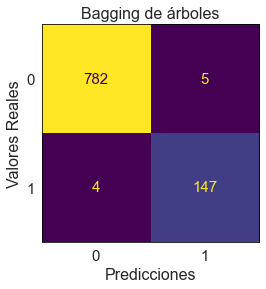

In [20]:
# Score y Confusion Matrix

# Evalúa el mejor modelo en tus datos de prueba
y_pred = selected_model.predict(X_test)

# Calcular la precisión de las predicciones en el conjunto de prueba
print(f"El valor de f1 score es: \n {f1_score(y_test, y_pred).round(3)}")
print(f"Otros estadísticos del test: \n {classification_report(y_test, y_pred)}")

# Matriz de confusión
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)

fig, ax = plt.subplots(figsize=(4, 4))
disp.plot(ax=ax, cmap='viridis', values_format='d', colorbar=False)
ax.grid(False) # Deshabilitar el grid de fondo

# plt.title('Matriz de confusión', fontsize=18) # Cambiar tamaño del título
ax.spines[['bottom','top','left','right']].set_color('black')
plt.title('Bagging de árboles', fontsize=16)
plt.xlabel('Predicciones', fontsize=16)
plt.ylabel('Valores Reales', fontsize=16)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
for text in ax.texts:
    text.set_fontsize(15)
plt.show()

### Importancia de las variables

In [13]:
## Importancia (promedio) de las variabs seleccionadas

# Iniciar vector con dim correcta
importances = np.zeros(len(select_names))

# A diferencia de RandomForestClassifier(), BaggingClassifier no tiene integrada la importancia
# promedio de las variabs. Pero sí la importancia en cada uno de sus árboles, así que podemos calcularla:

# n_estimators
n_trees = selected_model.named_steps['algorithm'].n_estimators

# Calculamos la importancia promedio de cada variab
for i in range(n_trees):
        importances = importances + selected_model.named_steps['algorithm'].estimators_[i].feature_importances_
        
importances /= n_trees # dividimos porque queremos el promedio

# comprobación
len(select_names) == len(importances)

True

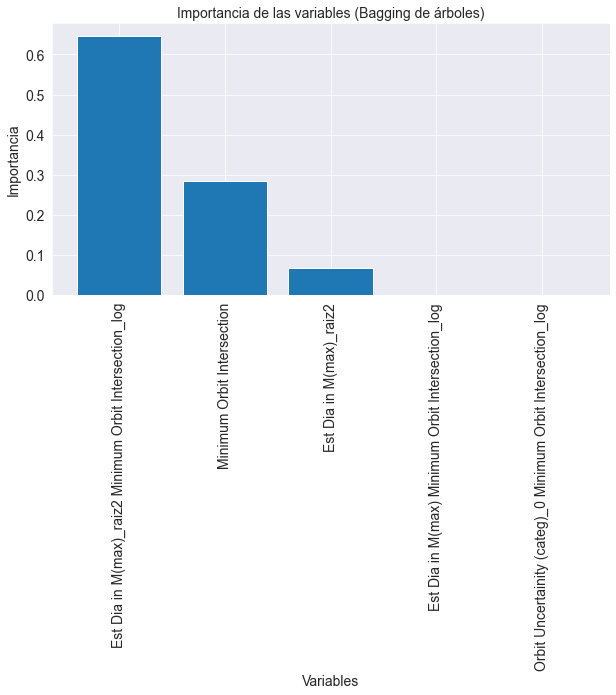

In [14]:
# Crear un dataframe con la información
df_importances = pd.DataFrame({'Variable': select_names, 'Importancia': importances})

# Ordenar las variables por su importancia
df_importances = df_importances.sort_values('Importancia', ascending=False)

# (recortar el nombre de las variabs, sino es muy largo)
df_importances['Variable'] = df_importances['Variable'].replace(['scaler__', 'encoder__'], '', regex=True)

# Gráfico de barras
plt.figure(figsize=(10,5))
# Como son demasiadas variabs, mostramos solo las n mejores:
n = 10 # esto al final no lo he usado, pero se puede dejar así
plt.bar(df_importances['Variable'][0:n], df_importances['Importancia'][0:n])
plt.xticks(rotation=90, fontsize=14)
plt.yticks(fontsize=14) 
plt.title('Importancia de las variables (Bagging de árboles)', fontsize=14) 
plt.xlabel('Variables', fontsize=14)
plt.ylabel('Importancia', fontsize=14)
plt.show()

In [21]:
import pickle

# Guarda los datos de puntuaciones
with open('cv_scores_model3.pkl', 'wb') as f:
    pickle.dump(cv_scores[modelo_optimo], f)

### [EXTRA] Recursive feature elimination

In [15]:
# # Dummificar la variab categ
# encoder = OneHotEncoder(drop=["3-9"])
# X_encoded = encoder.fit_transform(X_train[['Orbit Uncertainity (categ)']])

# # Crear un DataFrame a partir de la matriz codificada y asignar nombres a las columnas dummy
# X_dummies = pd.DataFrame(X_encoded.toarray(), columns=encoder.get_feature_names_out(['Orbit Uncertainity (categ)']))

# # X_encoded no conserva el índice original. 
# # X_train tiene los índices desordenados y además le faltan algunos índices intermedios (esto es lo normal por train_test_split).
# # Para no perder datos (presencia de nulls) al hacer el concat, hay que redefinir el índice de X_dummies:
# X_dummies = X_dummies.set_index(X_train.index)

# # Concatenar el DataFrame de variables numéricas con el DataFrame de variables dummy
# X_RFE = pd.concat([X_train.select_dtypes(include='number'), X_dummies], axis=1)

In [16]:
# # Indicar el RandomForestClassifier() a analizar
# rf = selected_model.named_steps['algorithm']

# # Use recursive feature elimination with cross-validation to select the top features
# rfe = RFECV(estimator=rf, step=1, cv=cv_technique, scoring='f1')
# rfe.fit(X_RFE, y_train)

#     ### SOSPECHO que RFECV es lo mismo que si meto RFE en mi pipeline y pasa por GridSearch
#     ## Comprobarlo???

# # Print the results
# print("Optimal number of features : %d" % rfe.n_features_)
# print("Selected features: ", rfe.support_)
# print("Feature rankings: ", rfe.ranking_)

In [17]:
# # Mejores variabs (según RFE)
# X_RFE.columns[rfe.ranking_ == 1]

# # Coincide con la importancia (es que en nuestro dataset en particular, está muy claro jaja)

In [18]:
# X_RFE.columns # comprobación (visual)